# Model Testing

## This notebook is meant to load trained models, and test their performance



In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from dataset_spectrogram import EEGDataset
from torch.utils.data import random_split
import neptune.new as neptune
from torchinfo import summary
from dataset_spectrogram import load_dataset
import random
import torch.utils.data as data
from datetime import datetime
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import mne

Spectrogram dataset version 20 non log


In [2]:
# Load a saved model

device = 'cuda' if torch.cuda.is_available() else 'cpu' #Check for cuda 
print(device)

model = torch.jit.load("../trained_models/model_05_15_2022_01_45_51",map_location=device)


cpu


### Load and test with 50-50 test dataset

In [ ]:
# Load the dataset
raw_data_dir = '../data'
testNights = 8

print("\nTest set\n")
test_set = load_dataset(range(testNights), raw_data_dir, normalized = False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, drop_last = True)

# Test the model on the test set

size = len(test_loader.dataset)
num_batches = len(test_loader)
correct = 0

# Truth table variables
true_pos,true_neg, false_pos, false_neg = 0,0,0,0

predicted_count = 0

with torch.no_grad():
    for X, y in test_loader:
        X = X[:,None,:,:].to(device)
        y = y.to(device)
        pred = model(X).reshape(-1).to(device) # Reshape to 1 dimension if using binary classification, otherwise keep dimensions from model output
        correct += (pred.round() == y).type(torch.float).sum().item()
        
        # Calculate the truth table
        for i, pred_val in enumerate(pred.round()):
            if y[i] == 1:
                if pred_val == 1:
                    true_pos += 1
                else:
                    false_neg += 1
            else:
                if pred_val == 1:
                    false_pos += 1
                else:
                    true_neg += 1
        
        predicted_count += 1
        if (predicted_count % 100) == 0:
            print("Batch: ", predicted_count, "Correct: ", correct, "Accuracy: ", correct/size, "Of", num_batches)
                    
        

correct /= size
print(f"Test accuracy: {correct}")
print(f"Test size: {size}")

# Print the truth table
print("\nTruth table\n")
print(f"True pos: {true_pos}")
print(f"True neg: {true_neg}")
print(f"False pos: {false_pos}")
print(f"False neg: {false_neg}")

print("\n\n")


### Load and test full night data

In [3]:
# Make a list of all the folders containing sleep data

raw_data_dir = '../data'
data_dirs = []

for subdir, dirs, files in sorted(os.walk(raw_data_dir)):
    if "night" in subdir and not ("calibration" in subdir or "scor" in subdir or "folder" in subdir):
        data_dirs.append(subdir)
        
print(f"{len(data_dirs)} nights found")       

77 nights found


In [4]:
# Load the spectrogram data from a night from the list
night_path = data_dirs[0]

time_series = np.load(f"{night_path}/EEG_raw_250hz.npy") # Load the raw EEG data
print('Time series data loaded')

f, t, Sxx = signal.spectrogram(time_series[:], fs=250,nperseg=250, noverlap=125) # Calculate the spectrogram
print('Spectrogram complete')

annotations = np.load(night_path+"/artefact_annotations.npy") # Load the annotations
print("Annotations loaded")

annotation_list,spectrogram_list, time_series_list = [],[],[] # Create lists to store the data

# Segment the data and test the model
for channel_number, channel in enumerate(Sxx): # Loop through each channel
    for i in range(channel.shape[1]): # Loop through each timepoint
        if (i % 20 == 0) and i < channel.shape[1] - 21: # Segment the data into 10s windows
            
            annotation_list.append(annotations[:,i*125:i*125+2500]) # Load annotations for the segment
            spectrogram_list.append(channel[:,i:i+20]) # Load the spectrogram for the segment
            time_series_list.append(time_series[:,i*125:i*125+2500]) # Load the time series for the segment
            pass # Do nothing

print("Lists created")


Time series data loaded
Spectrogram complete
Annotations loaded
Lists created


In [5]:
pred = []
for n in range(len(spectrogram_list)): # Loop through each segment
    if n % 64 == 0: # If the segment is a multiple of 64, predict the batch of segments
        print(f"Segment {n}/{len(spectrogram_list)}")     
        spectro_tensor = torch.from_numpy(np.array(spectrogram_list[n:n+64]))
        spectro_tensor = spectro_tensor[:,None,:,:]
        
        batch_pred = model(spectro_tensor) # Run the model on the segments
        for i in range(batch_pred.shape[0]): # Add the predictions to the list
            pred.append(float(batch_pred[i])) 
         
    
    # MNE normalize raw data 
    
    
    # Visualise the segment 
    # raw.plot(block=True)

Segment 0
Segment 64
Segment 128
Segment 192
Segment 256
Segment 320
Segment 384
Segment 448
Segment 512
Segment 576
Segment 640
Segment 704
Segment 768
Segment 832
Segment 896
Segment 960
Segment 1024
Segment 1088
Segment 1152
Segment 1216
Segment 1280
Segment 1344
Segment 1408
Segment 1472
Segment 1536
Segment 1600
Segment 1664
Segment 1728
Segment 1792
Segment 1856
Segment 1920
Segment 1984
Segment 2048
Segment 2112
Segment 2176
Segment 2240
Segment 2304
Segment 2368
Segment 2432
Segment 2496
Segment 2560
Segment 2624
Segment 2688
Segment 2752
Segment 2816
Segment 2880
Segment 2944
Segment 3008
Segment 3072
Segment 3136
Segment 3200
Segment 3264
Segment 3328
Segment 3392
Segment 3456
Segment 3520
Segment 3584
Segment 3648
Segment 3712
Segment 3776
Segment 3840
Segment 3904
Segment 3968
Segment 4032
Segment 4096
Segment 4160
Segment 4224
Segment 4288
Segment 4352
Segment 4416
Segment 4480
Segment 4544
Segment 4608
Segment 4672
Segment 4736
Segment 4800
Segment 4864
Segment 4928
Segme

#### Plot

Plotting segment
Index: 43946
Channel: 19


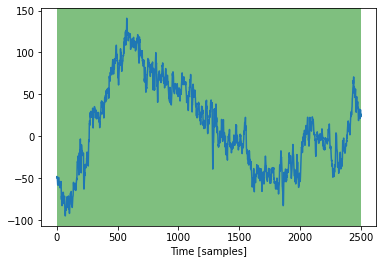

/tmp/ipykernel_234546/3447550676.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t[0:2500], labels, annotation_list[segment_index])


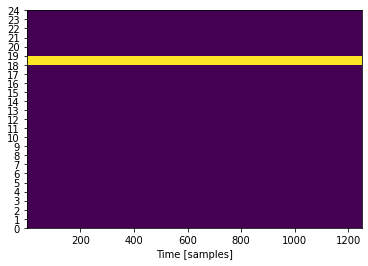

/tmp/ipykernel_234546/3447550676.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]))


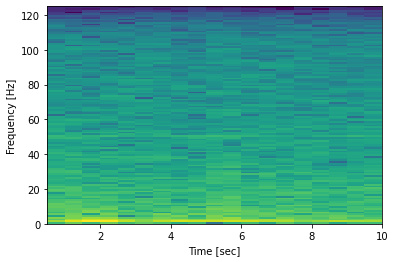

In [98]:
# Pick a random index of a segment to plot
if True:
    print("Plotting segment")
    segment_index = round(random.random()*len(time_series_list)) 
    print(f"Index: {segment_index}")
    channel = round(random.random()*24) 
    print(f"Channel: {channel}")

else: # To see the next segment instead of a random one
    segment_index += 1



# Convert time series to mne raw object
labels = list(range(25)) #MNE needs labels for channels (Numbers as placeholder. Should ideally be the correct labels)
labels = [str(i) for i in labels]
#raw = mne.io.RawArray(time_series_list[segment_index], info=mne.create_info(labels, 250))

# Plot time series using matplotlib
plt.plot(time_series_list[segment_index][channel])
for i, a in enumerate(annotation_list[segment_index][channel]):
    if a:
        plt.axvspan(i - 0.5, i + 0.5, facecolor='r', alpha=0.5)
    else:
        plt.axvspan(i - 0.5, i + 0.5, facecolor='g', alpha=0.5)
plt.xlabel('Time [samples]')
plt.show()

plt.pcolormesh(t[0:2500], labels, annotation_list[segment_index])
plt.xlabel('Time [samples]')
plt.show()
# Plot spectrogram using matplotlib
plt.pcolormesh(t[0:20], f, np.log(spectrogram_list[segment_index]))

plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
 



    